# Convolutional Neural Netrowk Model - DEAP dataValence emotion 
# (Three Classes)

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras import metrics
from keras import regularizers
import models.nnmodels as nn
import utils.data as data

import gc
gc.enable()
seed = 0
np.random.seed(seed)
%matplotlib inline

Using TensorFlow backend.


# Load data for three classes classification


In [2]:
print 'Loading DEAP dataset...'
subject_data_folds, valence_folds, arousal_folds = data.load_deap(32, 3)
print 'DEAP dataset is loaded.\n'

print 5*'#' + ' Dataset representation for each subject ' + 5*'#'
print '\nThere are {} subjects in the dataset.\n'.format(len(subject_data_folds))
print '(Trail/Video, Channel, Readings) : ', subject_data_folds[0].shape
print '(Trail/Video, label (valence or arousal)) : ', arousal_folds[0].shape



Loading DEAP dataset...
DEAP dataset is loaded.

##### Dataset representation for each subject #####

There are 32 subjects in the dataset.

(Trail/Video, Channel, Readings) :  (40, 40, 8064)
(Trail/Video, label (valence or arousal)) :  (40, 2)


# Reduce the features dimention (8064D >> 101D)
## Then Normalize the features

In [3]:
# Reduce the features dimension
print 'Mapping features into Gaussian with mean zero and unit variance...'
reduced_data_folds = data.normalize_features(subject_data_folds, flag=True)
print 'Normalization done.'

Mapping features into Gaussian with mean zero and unit variance...
Normalization done.


# Train CNN model for three classes (low Valence / mid Valence / High Valence) classification

##### Two Classes Classification for Valence emotion Using Convolutional Neural Network #####

Training model to test on subject 01 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.55000, saving model to ../saved_models/best_CNN_model_for_s01_valence(2classes).h5
Epoch 00040: val_categorical_accuracy improved from 0.55000 to 0.65000, saving model to ../saved_models/best_CNN_model_for_s01_valence(2classes).h5
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [=======================

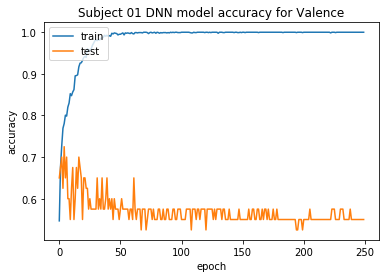

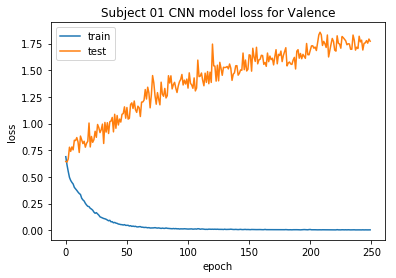

Training model to test on subject 02 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.80000, saving model to ../saved_models/best_CNN_model_for_s02_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 717us/step
#### Result of CNN model for subject 02 #####

Loss: 0.68939614296 , Accuracy : 80.0%


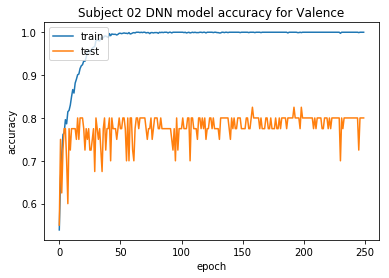

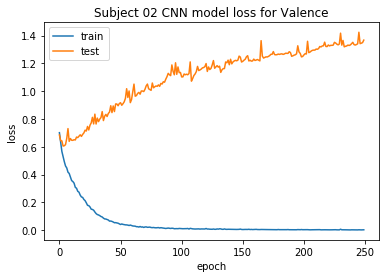

Training model to test on subject 03 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.67500, saving model to ../saved_models/best_CNN_model_for_s03_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 723us/step
#### Result of CNN model for subject 03 #####

Loss: 0.690148448944 , Accuracy : 67.5%


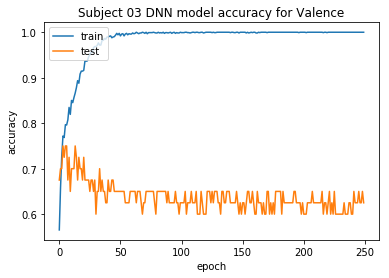

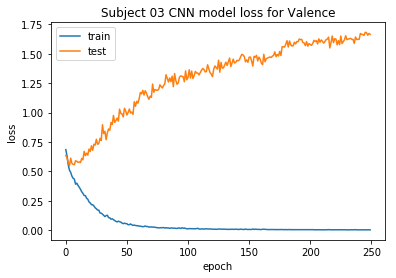

Training model to test on subject 04 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.70000, saving model to ../saved_models/best_CNN_model_for_s04_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 703us/step
#### Result of CNN model for subject 04 #####

Loss: 0.761652779579 , Accuracy : 70.0%


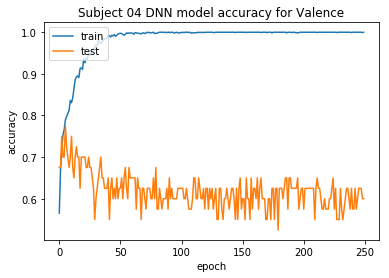

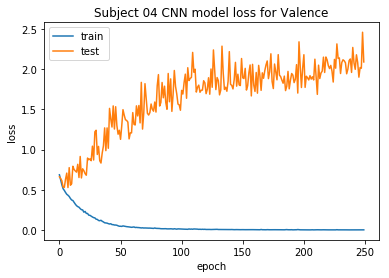

Training model to test on subject 05 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.70000, saving model to ../saved_models/best_CNN_model_for_s05_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy improved from 0.70000 to 0.72500, saving model to ../saved_models/best_CNN_model_for_s05_valence(2classes).h5
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 709us/step
#### Result of CNN model for subject 05 #####

Loss: 1.28520441055 , A

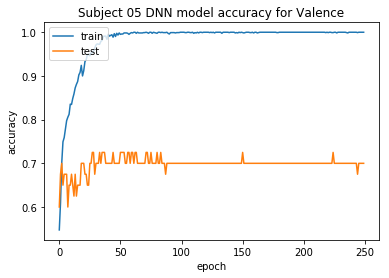

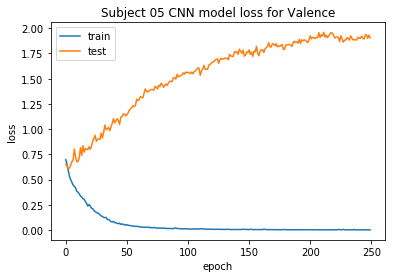

Training model to test on subject 06 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.77500, saving model to ../saved_models/best_CNN_model_for_s06_valence(2classes).h5
Epoch 00040: val_categorical_accuracy improved from 0.77500 to 0.80000, saving model to ../saved_models/best_CNN_model_for_s06_valence(2classes).h5
Epoch 00060: val_categorical_accuracy improved from 0.80000 to 0.82500, saving model to ../saved_models/best_CNN_model_for_s06_valence(2classes).h5
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [========================

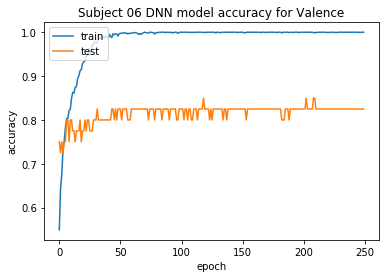

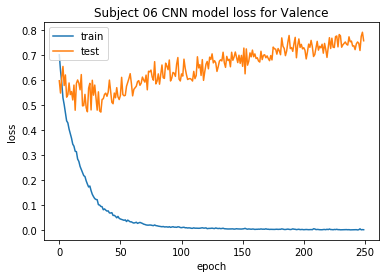

Training model to test on subject 07 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.67500, saving model to ../saved_models/best_CNN_model_for_s07_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 720us/step
#### Result of CNN model for subject 07 #####

Loss: 0.699256038666 , Accuracy : 67.5%


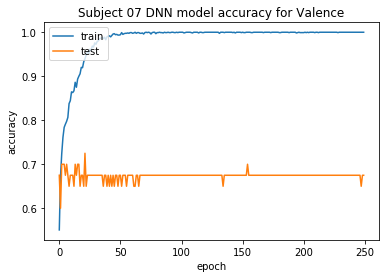

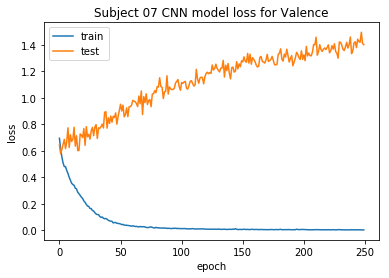

Training model to test on subject 08 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.65000, saving model to ../saved_models/best_CNN_model_for_s08_valence(2classes).h5
Epoch 00040: val_categorical_accuracy improved from 0.65000 to 0.70000, saving model to ../saved_models/best_CNN_model_for_s08_valence(2classes).h5
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy improved from 0.70000 to 0.72500, saving model to ../saved_models/best_CNN_model_for_s08_valence(2classes).h5
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy improved from 0.72500 to 0.75000, saving model 

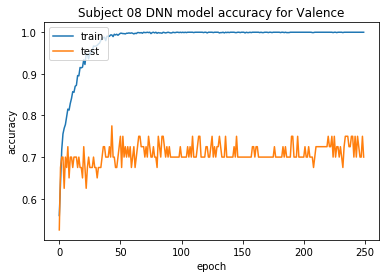

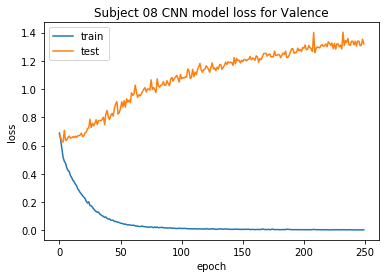

Training model to test on subject 09 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.77500, saving model to ../saved_models/best_CNN_model_for_s09_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 691us/step
#### Result of CNN model for subject 09 #####

Loss: 0.686730957031 , Accuracy : 77.5%


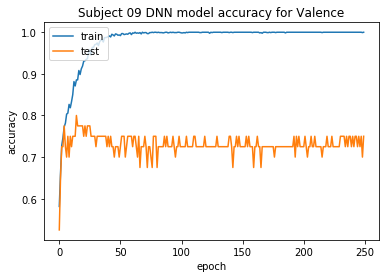

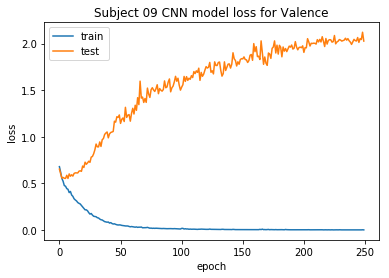

Training model to test on subject 10 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.80000, saving model to ../saved_models/best_CNN_model_for_s10_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 691us/step
#### Result of CNN model for subject 10 #####

Loss: 0.541806685925 , Accuracy : 80.0%


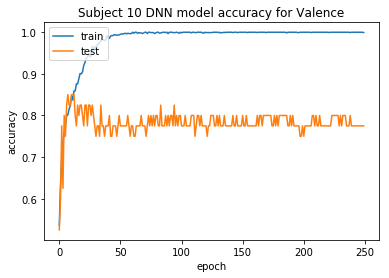

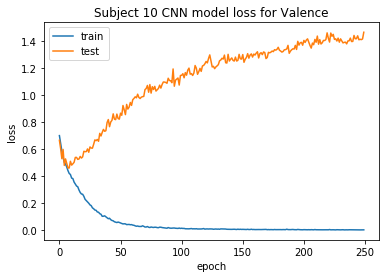

Training model to test on subject 11 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.40000, saving model to ../saved_models/best_CNN_model_for_s11_valence(2classes).h5
Epoch 00040: val_categorical_accuracy improved from 0.40000 to 0.55000, saving model to ../saved_models/best_CNN_model_for_s11_valence(2classes).h5
Epoch 00060: val_categorical_accuracy improved from 0.55000 to 0.57500, saving model to ../saved_models/best_CNN_model_for_s11_valence(2classes).h5
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [========================

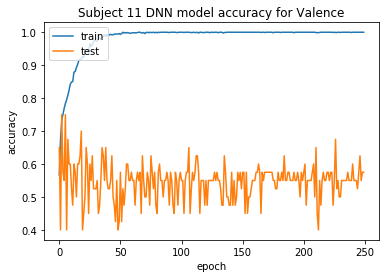

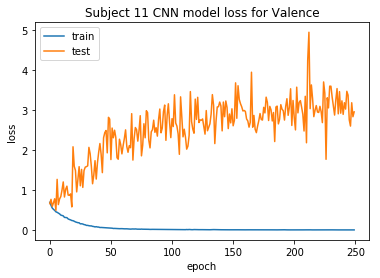

Training model to test on subject 12 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.72500, saving model to ../saved_models/best_CNN_model_for_s12_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 688us/step
#### Result of CNN model for subject 12 #####

Loss: 0.625720733404 , Accuracy : 72.5%


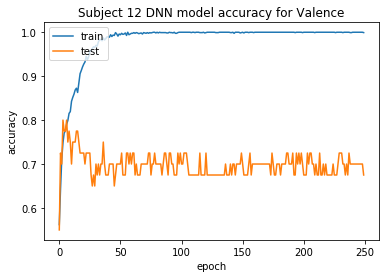

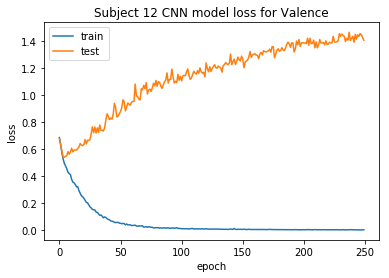

Training model to test on subject 13 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.80000, saving model to ../saved_models/best_CNN_model_for_s13_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 706us/step
#### Result of CNN model for subject 13 #####

Loss: 0.521111398935 , Accuracy : 80.0%


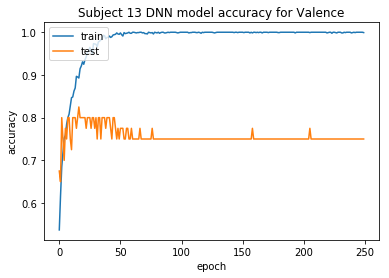

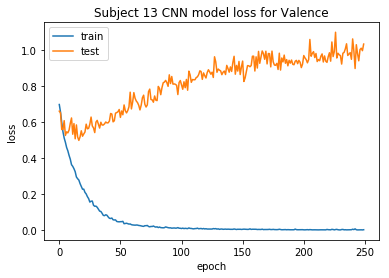

Training model to test on subject 14 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.67500, saving model to ../saved_models/best_CNN_model_for_s14_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy improved from 0.67500 to 0.70000, saving model to ../saved_models/best_CNN_model_for_s14_valence(2classes).h5
Epoch 00160: val_categorical_accuracy improved from 0.70000 to 0.72500, saving model to ../saved_models/best_CNN_model_for_s14_valence(2classes).h5
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [========================

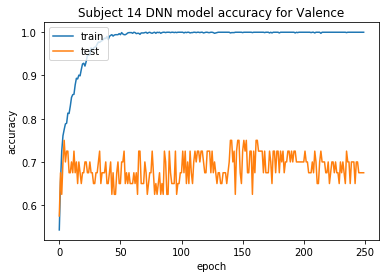

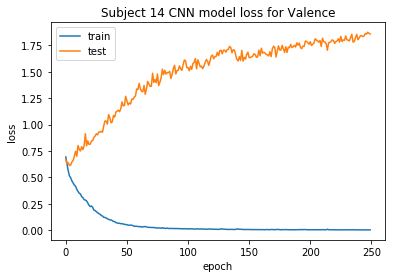

Training model to test on subject 15 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.65000, saving model to ../saved_models/best_CNN_model_for_s15_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 716us/step
#### Result of CNN model for subject 15 #####

Loss: 0.64108915329 , Accuracy : 65.0%


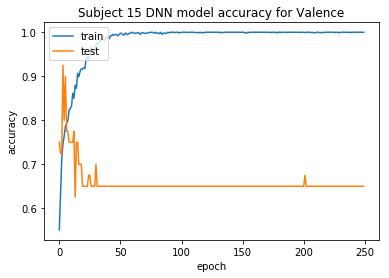

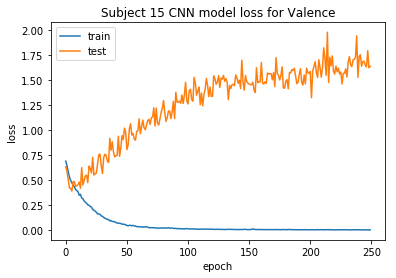

Training model to test on subject 16 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.60000, saving model to ../saved_models/best_CNN_model_for_s16_valence(2classes).h5
Epoch 00040: val_categorical_accuracy improved from 0.60000 to 0.62500, saving model to ../saved_models/best_CNN_model_for_s16_valence(2classes).h5
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 730us/step
#### Result of CNN model for subject 16 #####

Loss: 0.887509942055 , 

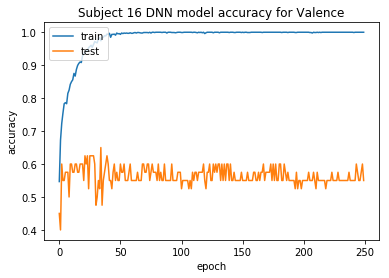

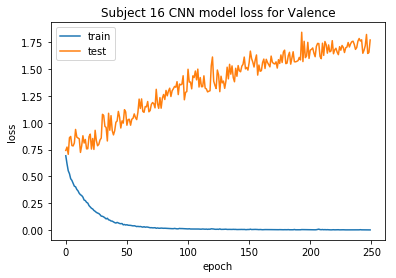

Training model to test on subject 17 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.75000, saving model to ../saved_models/best_CNN_model_for_s17_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 689us/step
#### Result of CNN model for subject 17 #####

Loss: 0.531984305382 , Accuracy : 75.0%


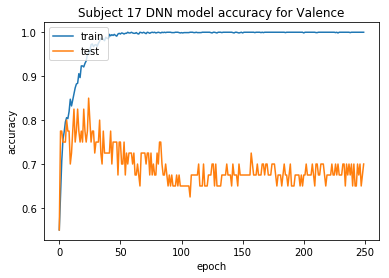

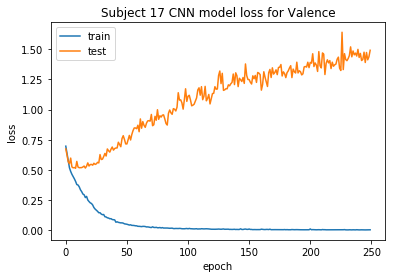

Training model to test on subject 18 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.72500, saving model to ../saved_models/best_CNN_model_for_s18_valence(2classes).h5
Epoch 00040: val_categorical_accuracy improved from 0.72500 to 0.80000, saving model to ../saved_models/best_CNN_model_for_s18_valence(2classes).h5
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 696us/step
#### Result of CNN model for subject 18 #####

Loss: 0.506477236748 , 

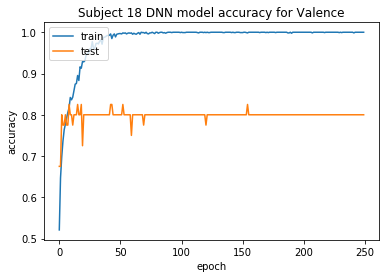

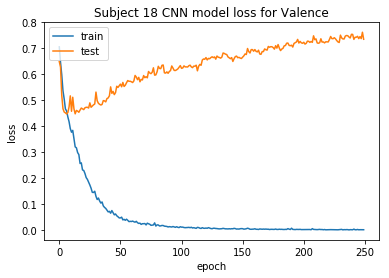

Training model to test on subject 19 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.80000, saving model to ../saved_models/best_CNN_model_for_s19_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 697us/step
#### Result of CNN model for subject 19 #####

Loss: 0.380333083868 , Accuracy : 80.0%


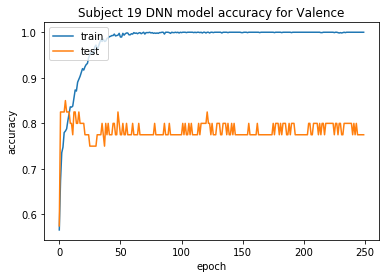

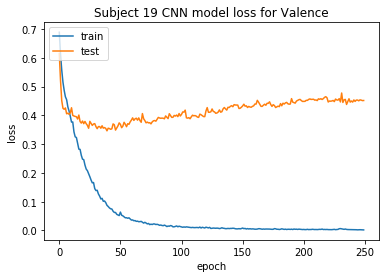

Training model to test on subject 20 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.85000, saving model to ../saved_models/best_CNN_model_for_s20_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 733us/step
#### Result of CNN model for subject 20 #####

Loss: 0.330136209726 , Accuracy : 85.0%


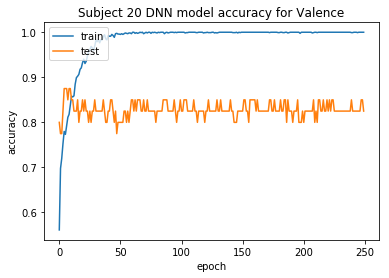

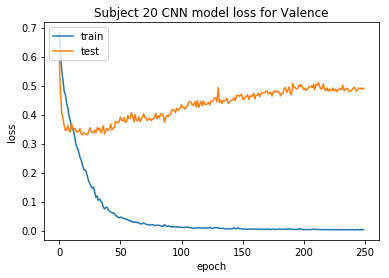

Training model to test on subject 21 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.70000, saving model to ../saved_models/best_CNN_model_for_s21_valence(2classes).h5
Epoch 00040: val_categorical_accuracy improved from 0.70000 to 0.72500, saving model to ../saved_models/best_CNN_model_for_s21_valence(2classes).h5
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy improved from 0.72500 to 0.75000, saving model to ../saved_models/best_CNN_model_for_s21_valence(2classes).h5
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [========================

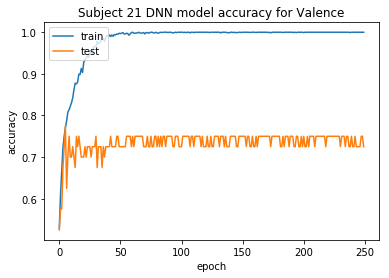

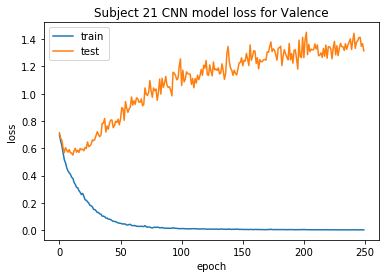

Training model to test on subject 22 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.60000, saving model to ../saved_models/best_CNN_model_for_s22_valence(2classes).h5
Epoch 00040: val_categorical_accuracy improved from 0.60000 to 0.70000, saving model to ../saved_models/best_CNN_model_for_s22_valence(2classes).h5
Epoch 00060: val_categorical_accuracy improved from 0.70000 to 0.75000, saving model to ../saved_models/best_CNN_model_for_s22_valence(2classes).h5
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy improved from 0.75000 to 0.77500, saving model to ../saved_models/best_CNN_model_for_s22_valence(2classes).h5
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not

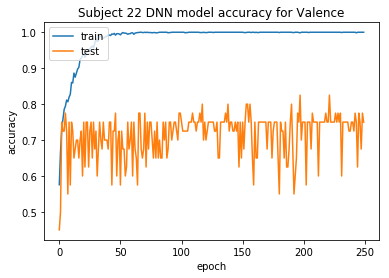

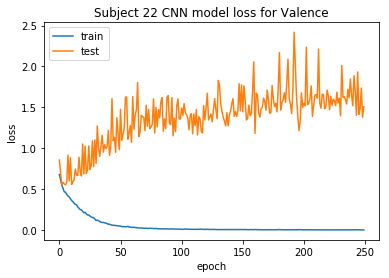

Training model to test on subject 23 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.80000, saving model to ../saved_models/best_CNN_model_for_s23_valence(2classes).h5
Epoch 00040: val_categorical_accuracy improved from 0.80000 to 0.82500, saving model to ../saved_models/best_CNN_model_for_s23_valence(2classes).h5
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 701us/step
#### Result of CNN model for subject 23 #####

Loss: 0.573195099831 , 

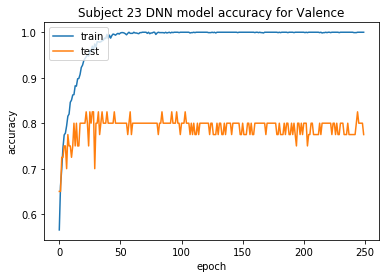

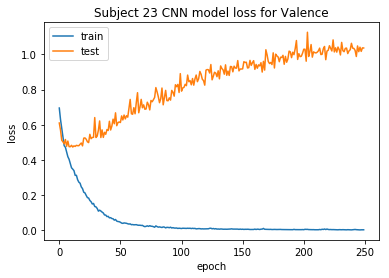

Training model to test on subject 24 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.75000, saving model to ../saved_models/best_CNN_model_for_s24_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 709us/step
#### Result of CNN model for subject 24 #####

Loss: 0.543192112446 , Accuracy : 75.0%


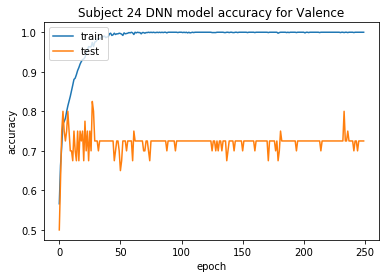

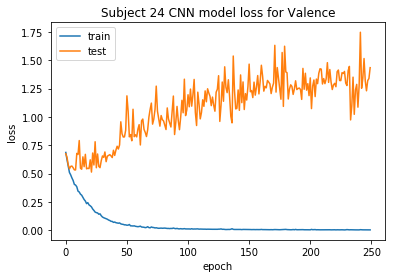

Training model to test on subject 25 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.65000, saving model to ../saved_models/best_CNN_model_for_s25_valence(2classes).h5
Epoch 00040: val_categorical_accuracy improved from 0.65000 to 0.67500, saving model to ../saved_models/best_CNN_model_for_s25_valence(2classes).h5
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 730us/step
#### Result of CNN model for subject 25 #####

Loss: 1.33206634223 , A

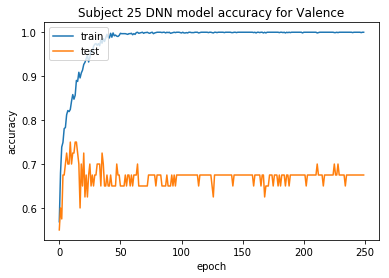

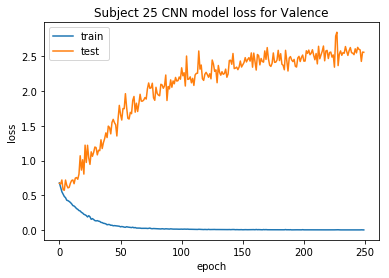

Training model to test on subject 26 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.52500, saving model to ../saved_models/best_CNN_model_for_s26_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy improved from 0.52500 to 0.57500, saving model to ../saved_models/best_CNN_model_for_s26_valence(2classes).h5
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 709us/step
#### Result of CNN model for subject 26 #####

Loss: 1.56617109179 , A

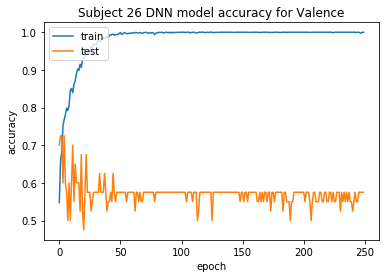

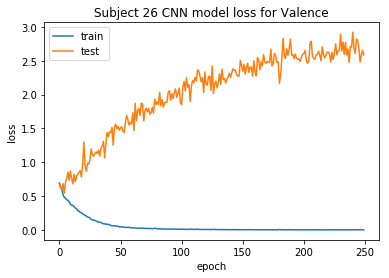

Training model to test on subject 27 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.57500, saving model to ../saved_models/best_CNN_model_for_s27_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 727us/step
#### Result of CNN model for subject 27 #####

Loss: 0.819073581696 , Accuracy : 57.5%


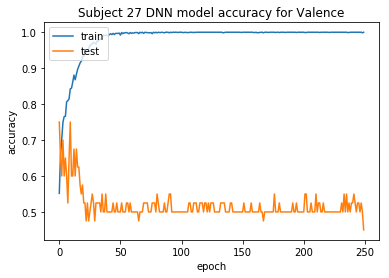

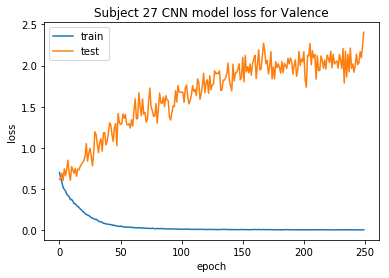

Training model to test on subject 28 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.75000, saving model to ../saved_models/best_CNN_model_for_s28_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy improved from 0.75000 to 0.77500, saving model to ../saved_models/best_CNN_model_for_s28_valence(2classes).h5
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy improved from 0.77500 to 0.80000, saving model to ../saved_models/best_CNN_model_for_s28_valence(2classes).h5
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [========================

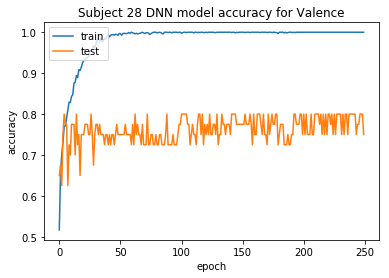

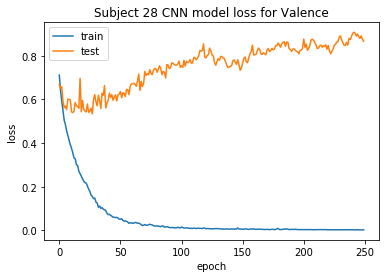

Training model to test on subject 29 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.75000, saving model to ../saved_models/best_CNN_model_for_s29_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy did not improve
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve
Epoch 00160: val_categorical_accuracy did not improve
Epoch 00180: val_categorical_accuracy did not improve
Epoch 00200: val_categorical_accuracy did not improve
Epoch 00220: val_categorical_accuracy did not improve
Epoch 00240: val_categorical_accuracy did not improve
40/40 [==============================] - 0s 717us/step
#### Result of CNN model for subject 29 #####

Loss: 0.561936688423 , Accuracy : 75.0%


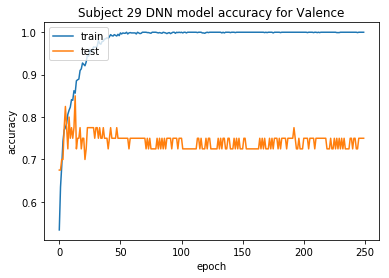

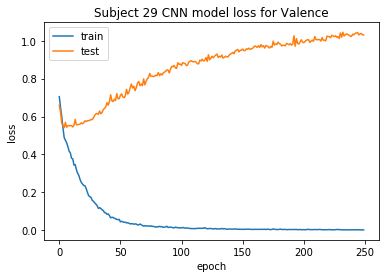

Training model to test on subject 30 ...

Epoch 00020: val_categorical_accuracy improved from -inf to 0.65000, saving model to ../saved_models/best_CNN_model_for_s30_valence(2classes).h5
Epoch 00040: val_categorical_accuracy did not improve
Epoch 00060: val_categorical_accuracy did not improve
Epoch 00080: val_categorical_accuracy improved from 0.65000 to 0.67500, saving model to ../saved_models/best_CNN_model_for_s30_valence(2classes).h5
Epoch 00100: val_categorical_accuracy did not improve
Epoch 00120: val_categorical_accuracy did not improve
Epoch 00140: val_categorical_accuracy did not improve


In [ ]:
num_exp = 40
num_classes = 3
batch_size = 50
epochs = 250
num_subjects = 32


accuracies= []

print '##### Three Classes Classification for Valence emotion Using Convolutional Neural Network #####\n'
   

for s in np.arange(0, num_subjects):
    
    
    X_val = reduced_data_folds[s]
    X_val = X_val.reshape(X_val.shape[0], 1, 40, 101)
    y_val = valence_folds[s]
    
    X_remaining_folds = reduced_data_folds[:s] + reduced_data_folds[s+1:]
    y_remaining_folds = valence_folds[:s] + valence_folds[s+1:]
    
    X_train = np.concatenate(X_remaining_folds)
    X_train = X_train.reshape(X_train.shape[0], 1, 40, 101)
    
    y_train = np.concatenate(y_remaining_folds)
    
    
    key = 's'+str(s+1).zfill(2)+'_valence(3classes)'
    
    
    # Valence classification model for three classes    
    model = nn.CNN(num_classes=num_classes, emotion='valence')
    
    
    # checkpoint
    filepath="../saved_models/best_CNN_model_for_{}.h5".format(key)
    
    print 'Training model to test on subject {} ...\n'.format(str(s+1).zfill(2))
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy',
                                verbose=1, save_best_only=True, mode='max', period=20)
    
    callbacks_list = [checkpoint]
    
    
    hist = model.fit(X_train, y_train, 
             batch_size=batch_size,
             epochs=epochs,
             shuffle=True,
             verbose=0,
             validation_data=(X_val, y_val), callbacks=callbacks_list)

    
    
    model.load_weights(filepath)
    
    scores = model.evaluate(x=X_val, y=y_val)
    
    
    
    print '#### Result of CNN model for subject {} #####\n'.format(str(s+1).zfill(2))
    print "Loss: {} , Accuracy : {}%".format(scores[0], scores[1]*100)
    
    

    accuracies.append(scores[1])
    # summarize history for accuracy
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Subject ' +str(s+1).zfill(2)+ ' DNN model accuracy for Valence')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Subject ' +str(s+1).zfill(2)+ ' CNN model loss for Valence')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    del model
 

   

# Accuracies

In [8]:

min_acc_subject_idx, max_acc_subject_idx = argmin(accuracies), np.argmax(accuracies)

avg_acc =  reduce(lambda x, y: x + y, accuracies) / len(accuracies)

print 5*'#' + ' Accuracies per subject ' + 5*'#'

print 'Subject {} has the minimum accuracy : {}'.format(min_acc_subject_idx + 1, min(accuracies))
print 'Subject {} has the maximum accuracy : {}'.format(max_acc_subject_idx + 1, max(accuracies))

for subj in enumerate(accuracies):
    print 'Accuracy of Subject {} : {}'.format(subj+1, accuracies[subj])

15 19
0.76171875


[0.72499999999999998,
 0.82499999999999996,
 0.72499999999999998,
 0.69999999999999996,
 0.69999999999999996,
 0.72499999999999998,
 0.72499999999999998,
 0.77500000000000002,
 0.77500000000000002,
 0.82499999999999996,
 0.65000000000000002,
 0.84999999999999998,
 0.77500000000000002,
 0.84999999999999998,
 0.84999999999999998,
 0.52500000000000002,
 0.80000000000000004,
 0.82499999999999996,
 0.82499999999999996,
 0.90000000000000002,
 0.75,
 0.82499999999999996,
 0.75,
 0.84999999999999998,
 0.75,
 0.67500000000000004,
 0.59999999999999998,
 0.80000000000000004,
 0.75,
 0.72499999999999998,
 0.80000000000000004,
 0.75]